In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/NICOS_NN/SOLSTICIO2_0'
input_pkl_path_v1 = os.path.join(data_dir, 'input_nn_ver1.pkl')
#input_pkl_path_v2 = os.path.join(data_dir, 'input_nn_ver2.pkl')

In [ ]:
df = pd.read_pickle(input_pkl_path_v1)
#df = pd.read_pickle(input_pkl_path_v2)

**------------------NOISE ADDING----------------------**

In [ ]:
def add_noise(tsky, trx=75.0, snr=1000.0):
    tsys = trx + tsky
    tnoise = tsys / snr
    tcal = tsky + tnoise * np.random.standard_normal(tsky.shape)
    return tcal

In [ ]:
original_spectrum = np.array(df['SPECTRA_Tb[K]'].iloc[0])

In [ ]:
frequencies = np.linspace(20.0, 26.0, len(original_spectrum))

In [ ]:
noisy_spectrum = add_noise(original_spectrum)

In [ ]:
df['SPECTRA_Tb[K]_NOISY'] = df['SPECTRA_Tb[K]']

**TRANING WAY 1: USING DIFFERENT COLUMNS BETWEEN PL AND H2O**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = np.array(df['SPECTRA_Tb[K]_NOISY'].tolist())
PL = np.array(df['PL[mbar]'].tolist())
H2O = np.array(df['H2O[vmr]'].tolist())
Y = np.concatenate([H2O, PL], axis=1)

In [ ]:
print(H2O.shape, PL.shape)

(21024, 67) (21024, 67)


In [ ]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [ ]:
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)

X_train: (12614, 12001)
X_val:   (4205, 12001)
X_test:  (4205, 12001)


In [ ]:
print("Y_train:", Y_train.shape)
print("Y_val:  ", Y_val.shape)
print("Y_test: ", Y_test.shape)

Y_train: (12614, 134)
Y_val:   (4205, 134)
Y_test:  (4205, 134)


**SECOND FRAMEWORK TORCH**

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


**-NORMALIZATION-**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
#X_test_scaled = scaler.transform(X_test)
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

In [ ]:
scaler_y = StandardScaler()
Y_train = scaler_y.fit_transform(Y_train)
Y_val   = scaler_y.transform(Y_val)
Y_test  = scaler_y.transform(Y_test)

In [ ]:
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_val:  ", Y_val.shape)
print("Y_test: ", Y_test.shape)

X_train: (12614, 12001)
X_val:   (4205, 12001)
X_test:  (4205, 12001)
Y_train: (12614, 134)
Y_val:   (4205, 134)
Y_test:  (4205, 134)


**-----------------------**

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
Y_val   = torch.tensor(Y_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
Y_test  = torch.tensor(Y_test, dtype=torch.float32)

In [ ]:
batch_size = 64

In [ ]:
train_ds = TensorDataset(X_train, Y_train)
val_ds   = TensorDataset(X_val, Y_val)
test_ds  = TensorDataset(X_test, Y_test)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Project input if dimensions don’t match
        self.shortcut = nn.Identity()
        if in_features != out_features:
            self.shortcut = nn.Linear(in_features, out_features)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear(x)
        out = self.relu(out)
        out = self.dropout(out)
        return identity + out  # Residual connection

In [ ]:
class PedroSplitMLPResidual(nn.Module):
    def __init__(self):
        super(PedroSplitMLPResidual, self).__init__()
        self.fc_in = nn.Linear(12001, 1024)
        self.dropout_in = nn.Dropout(0.2)

        # Residual blocks
        self.res1 = ResidualBlock(1024, 512, dropout=0.2)
        self.res2 = ResidualBlock(512, 256, dropout=0.2)
        self.res3 = ResidualBlock(256, 128, dropout=0.2)

        # Output heads
        self.h2o_head = nn.Linear(128, 67)
        self.pl_head = nn.Linear(128, 67)

    def forward(self, x):
        x = torch.relu(self.fc_in(x))
        x = self.dropout_in(x)

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)

        h2o_out = self.h2o_head(x)
        pl_out = self.pl_head(x)
        return h2o_out, pl_out

model = PedroSplitMLPResidual()

In [ ]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = torch.tensor(weights, dtype=torch.float32)

    def forward(self, pred, target):
        diff = pred - target
        weighted_diff = diff * self.weights
        loss = torch.mean(weighted_diff ** 2)
        return loss

def smoothness_penalty(h2o_pred, alpha):
    diff = h2o_pred[:, 1:] - h2o_pred[:, :-1]
    return alpha * torch.mean(diff ** 2)

# Construct weights to emphasize lower pressures (higher in atmosphere)
n_levels = 67
pl_weights = np.linspace(1.0, 0.5, n_levels)      # Normal weights for PL
h2o_weights = np.logspace(np.log10(2.0), np.log10(0.8), n_levels)     # Emphasize high-altitude H2O, modified for higher-pressure performance

pl_weights_tensor = torch.tensor(pl_weights, dtype=torch.float32)
h2o_weights_tensor = torch.tensor(h2o_weights, dtype=torch.float32)

combined_weights = np.concatenate([pl_weights, h2o_weights])
criterion_h2o = WeightedMSELoss(weights=h2o_weights_tensor)
criterion_pl  = WeightedMSELoss(weights=pl_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

/tmp/ipython-input-26-2966828005.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.float32)


In [ ]:
def train(model, loader, val_loader, criterion_h2o, criterion_pl, optimizer, epochs, save_path, alpha, lambda_h2o):
    train_losses, val_losses = [], []
    val_mae_list, val_rmse_list = [], []

    best_val_loss = float('inf')
    patience = 15
    counter = 0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()

            h2o_pred, pl_pred = model(xb)
            h2o_target = yb[:, :n_levels]
            pl_target = yb[:, n_levels:]

            loss_h2o = criterion_h2o(h2o_pred, h2o_target)
            loss_pl = criterion_pl(pl_pred, pl_target)
            smooth_loss = smoothness_penalty(h2o_pred, alpha=alpha)

            loss = lambda_h2o * loss_h2o + loss_pl + smooth_loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(loader))

        # VALIDATION
        model.eval()
        val_loss_total = 0
        y_true_h2o, y_pred_h2o = [], []
        y_true_pl, y_pred_pl = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                h2o_pred, pl_pred = model(xb)
                h2o_target = yb[:, :n_levels]
                pl_target = yb[:, n_levels:]

                loss_h2o_val = criterion_h2o(h2o_pred, h2o_target)
                loss_pl_val = criterion_pl(pl_pred, pl_target)
                smooth_loss_val = smoothness_penalty(h2o_pred, alpha=alpha)

                batch_val_loss = lambda_h2o * loss_h2o_val + loss_pl_val + smooth_loss_val
                val_loss_total += batch_val_loss.item()

                y_true_h2o.append(h2o_target.cpu().numpy())
                y_pred_h2o.append(h2o_pred.cpu().numpy())

                y_true_pl.append(pl_target.cpu().numpy())
                y_pred_pl.append(pl_pred.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_losses.append(val_loss)

        y_true_h2o = np.concatenate(y_true_h2o, axis=0)
        y_pred_h2o = np.concatenate(y_pred_h2o, axis=0)

        y_true_pl = np.concatenate(y_true_pl, axis=0)
        y_pred_pl = np.concatenate(y_pred_pl, axis=0)

        # METRICS
        val_mae_h2o = mean_absolute_error(y_true_h2o, y_pred_h2o)
        val_rmse_h2o = np.sqrt(mean_squared_error(y_true_h2o, y_pred_h2o))

        val_mae_pl = mean_absolute_error(y_true_pl, y_pred_pl)
        val_rmse_pl = np.sqrt(mean_squared_error(y_true_pl, y_pred_pl))

        val_mae_list.append((val_mae_h2o, val_mae_pl))
        val_rmse_list.append((val_rmse_h2o, val_rmse_pl))

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            counter = 0
            print(f"✅ Model improved and saved (val_loss = {best_val_loss:.4f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"⛔ Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f} | "
              f"MAE H2O: {val_mae_h2o:.4f} | RMSE H2O: {val_rmse_h2o:.4f} | "
              f"MAE PL: {val_mae_pl:.4f} | RMSE PL: {val_rmse_pl:.4f} | LR: {current_lr:.1e}")

    model.load_state_dict(torch.load(save_path))
    return train_losses, val_losses, val_mae_list, val_rmse_list

In [ ]:
def evaluate(model, loader):
    model.eval()
    y_true_h2o, y_pred_h2o = [], []
    y_true_pl, y_pred_pl = [], []

    with torch.no_grad():
        for xb, yb in loader:
            h2o_pred, pl_pred = model(xb)
            h2o_target = yb[:, :n_levels]
            pl_target = yb[:, n_levels:]

            y_true_h2o.append(h2o_target.cpu().numpy())
            y_pred_h2o.append(h2o_pred.cpu().numpy())

            y_true_pl.append(pl_target.cpu().numpy())
            y_pred_pl.append(pl_pred.cpu().numpy())

    y_true_h2o = np.concatenate(y_true_h2o, axis=0)
    y_pred_h2o = np.concatenate(y_pred_h2o, axis=0)

    y_true_pl = np.concatenate(y_true_pl, axis=0)
    y_pred_pl = np.concatenate(y_pred_pl, axis=0)

    return (y_true_h2o, y_pred_h2o), (y_true_pl, y_pred_pl)

In [ ]:
save_path = '/content/drive/MyDrive/NICOS_NN/SOLSTICIO2_0/pedro_model22RES.pth'

In [ ]:
epochs = 300
alpha = 0.01  # Regularization strength for smoothness penalty
lambda_h2o=0.3
train_losses, val_losses, val_mae, val_rmse = train(
    model,
    train_loader,
    val_loader,
    criterion_h2o,
    criterion_pl,
    optimizer,
    epochs,
    save_path=save_path,
    alpha=alpha,
    lambda_h2o=lambda_h2o
)

✅ Model improved and saved (val_loss = 0.6260)
Epoch 1/300 | Train Loss: 0.8515 | Val Loss: 0.6260 | MAE H2O: 0.5144 | RMSE H2O: 0.7008 | MAE PL: 0.3961 | RMSE PL: 0.7215 | LR: 5.0e-04
✅ Model improved and saved (val_loss = 0.5906)
Epoch 2/300 | Train Loss: 0.5938 | Val Loss: 0.5906 | MAE H2O: 0.5039 | RMSE H2O: 0.7010 | MAE PL: 0.3421 | RMSE PL: 0.6983 | LR: 5.0e-04
✅ Model improved and saved (val_loss = 0.5255)
Epoch 3/300 | Train Loss: 0.5581 | Val Loss: 0.5255 | MAE H2O: 0.4879 | RMSE H2O: 0.6575 | MAE PL: 0.2922 | RMSE PL: 0.6403 | LR: 5.0e-04
Epoch 4/300 | Train Loss: 0.5305 | Val Loss: 0.6431 | MAE H2O: 0.4710 | RMSE H2O: 0.6682 | MAE PL: 0.4407 | RMSE PL: 0.8033 | LR: 5.0e-04
✅ Model improved and saved (val_loss = 0.4877)
Epoch 5/300 | Train Loss: 0.5198 | Val Loss: 0.4877 | MAE H2O: 0.4266 | RMSE H2O: 0.6099 | MAE PL: 0.2921 | RMSE PL: 0.6416 | LR: 5.0e-04
Epoch 6/300 | Train Loss: 0.5158 | Val Loss: 0.4981 | MAE H2O: 0.4551 | RMSE H2O: 0.6240 | MAE PL: 0.3457 | RMSE PL: 0.648

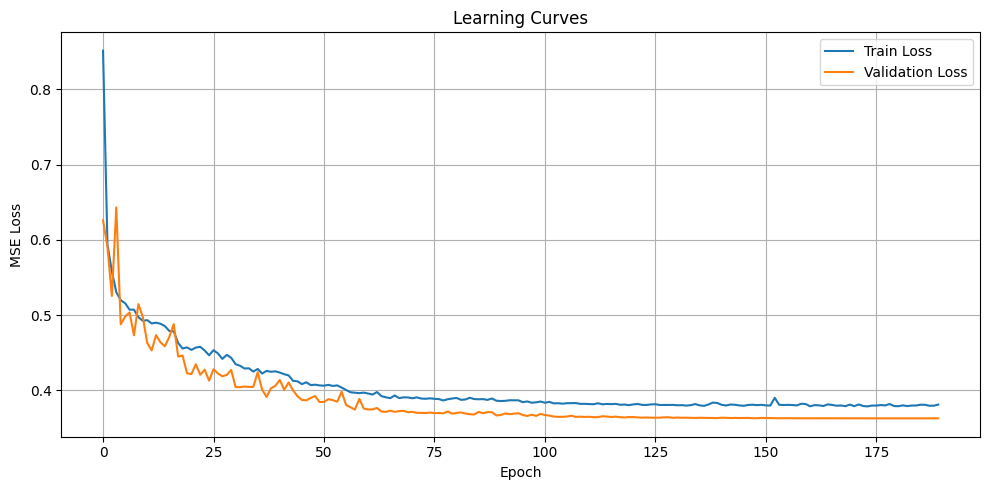

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Correct unpacking from evaluate
(y_true_h2o, y_pred_h2o), (y_true_pl, y_pred_pl) = evaluate(model, test_loader)

# Concatenate outputs
y_pred_test_scaled = np.concatenate([y_pred_h2o, y_pred_pl], axis=1)
y_true_test_scaled = np.concatenate([y_true_h2o, y_true_pl], axis=1)

# Inverse transform
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_true_test = scaler_y.inverse_transform(y_true_test_scaled)

# Split again
y_pred_h2o = y_pred_test[:, :67]
y_pred_pl  = y_pred_test[:, 67:]

y_true_h2o = y_true_test[:, :67]
y_true_pl  = y_true_test[:, 67:]

# Optionally concatenate to compute overall metrics
y_true_test = np.concatenate([y_true_pl, y_true_h2o], axis=1)
y_pred_test = np.concatenate([y_pred_pl, y_pred_h2o], axis=1)

# Compute test metrics
test_mae = mean_absolute_error(y_true_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print(f"\n✅ Test MAE:  {test_mae:.4f}")
print(f"✅ Test RMSE: {test_rmse:.4f}")

# You can also compute them separately:
mae_h2o = mean_absolute_error(y_true_h2o, y_pred_h2o)
rmse_h2o = np.sqrt(mean_squared_error(y_true_h2o, y_pred_h2o))

mae_pl = mean_absolute_error(y_true_pl, y_pred_pl)
rmse_pl = np.sqrt(mean_squared_error(y_true_pl, y_pred_pl))

print(f"\n🌊 H2O  → MAE: {mae_h2o:.4f} | RMSE: {rmse_h2o:.4f}")
print(f"📉 PL   → MAE: {mae_pl:.4f} | RMSE: {rmse_pl:.4f}")


✅ Test MAE:  1.2245
✅ Test RMSE: 4.4858

🌊 H2O  → MAE: 0.0004 | RMSE: 0.0011
📉 PL   → MAE: 2.4486 | RMSE: 6.3439


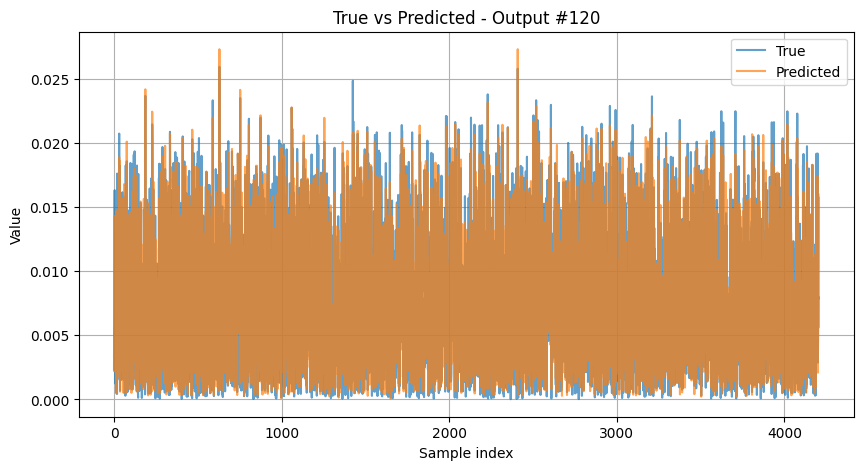

In [ ]:
output_index = 120  # index within concatenated output (0–133)

plt.figure(figsize=(10, 5))
plt.plot(y_true_test[:, output_index], label='True', alpha=0.7)
plt.plot(y_pred_test[:, output_index], label='Predicted', alpha=0.7)
plt.title(f"True vs Predicted - Output #{output_index}")
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

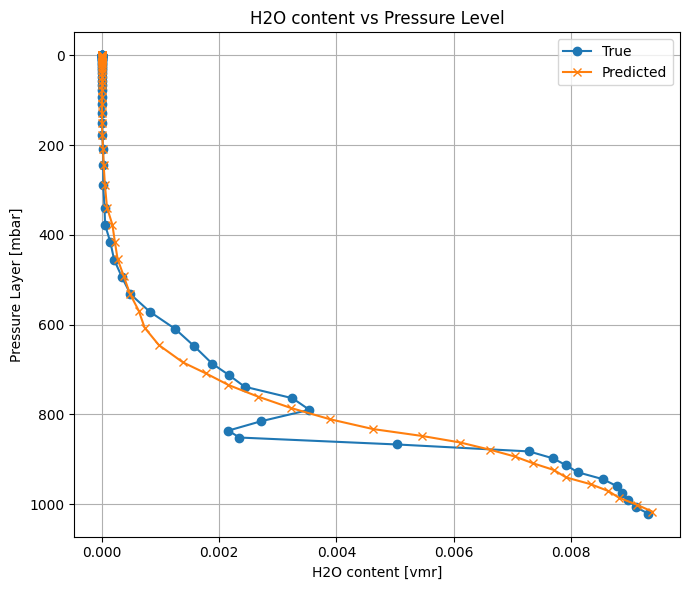

In [ ]:
# Choose a sample index
i = 120

# Extract profiles for test sample i
pl_profile_true = y_true_pl[i]
h2o_profile_true = y_true_h2o[i]

pl_profile_pred = y_pred_pl[i]
h2o_profile_pred = y_pred_h2o[i]

# Plot profile
plt.figure(figsize=(7, 6))
plt.plot(h2o_profile_true, pl_profile_true, label="True", marker='o')
plt.plot(h2o_profile_pred, pl_profile_pred, label="Predicted", marker='x')
plt.gca().invert_yaxis()
plt.xlabel("H2O content [vmr]")
plt.ylabel("Pressure Layer [mbar]")
#plt.ylim(0, 1000)
plt.title("H2O content vs Pressure Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

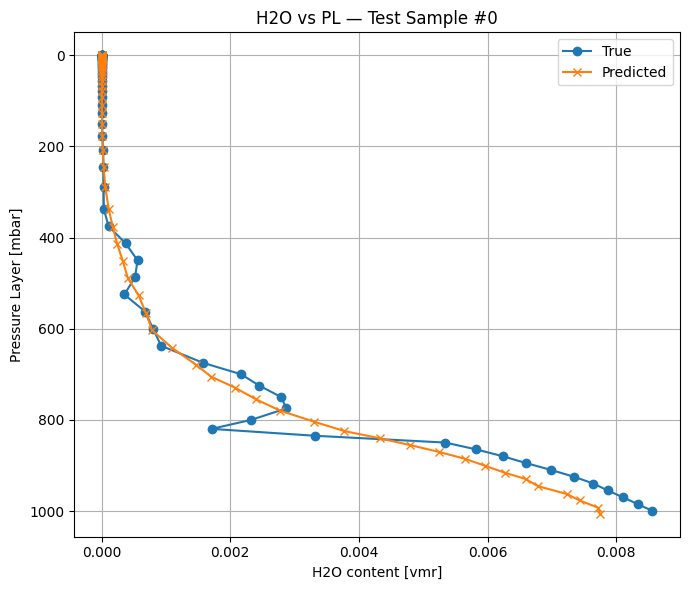

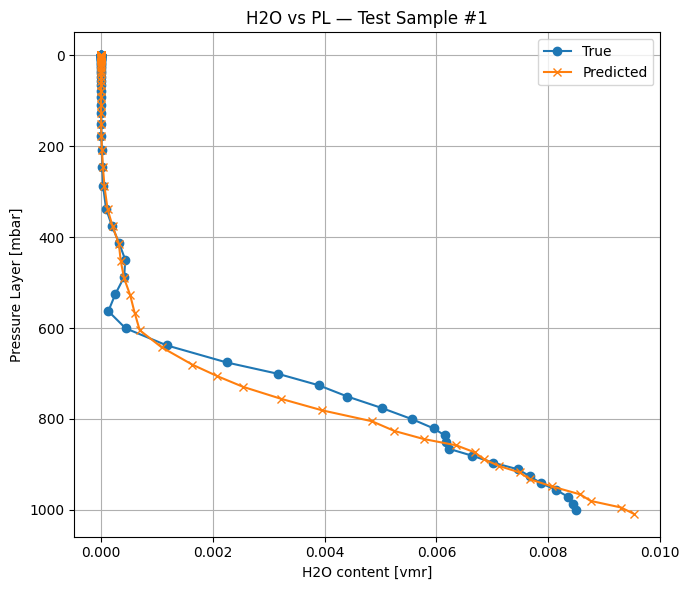

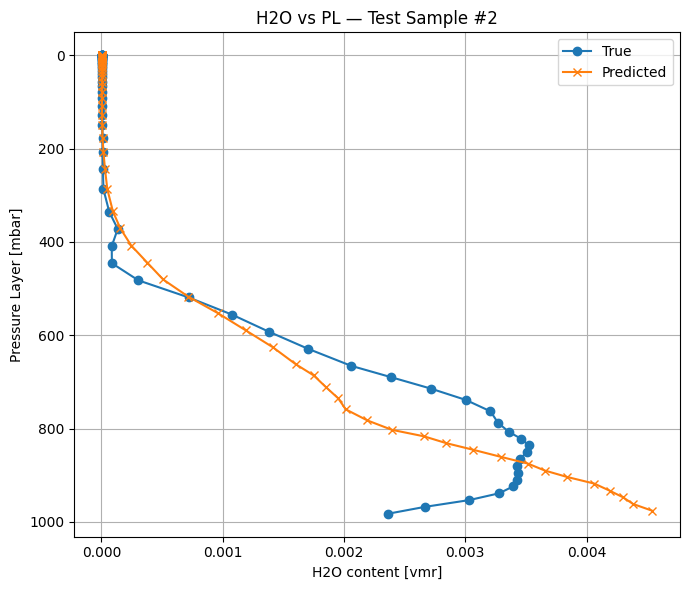

In [ ]:
for i in range(3):
    pl_profile_true = y_true_pl[i]
    h2o_profile_true = y_true_h2o[i]
    pl_profile_pred = y_pred_pl[i]
    h2o_profile_pred = y_pred_h2o[i]

    plt.figure(figsize=(7, 6))
    plt.plot(h2o_profile_true, pl_profile_true, label="True", marker='o')
    plt.plot(h2o_profile_pred, pl_profile_pred, label="Predicted", marker='x')
    plt.gca().invert_yaxis()
    plt.xlabel("H2O content [vmr]")
    plt.ylabel("Pressure Layer [mbar]")
    #plt.ylim(0, 1000)
    plt.title(f"H2O vs PL — Test Sample #{i}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#torch.save(model.state_dict(), save_path)

In [ ]:
save_path_final = '/content/drive/MyDrive/NICOS_NN/SOLSTICIO2_0/pedro_model22RES_final.pth'
torch.save(model.state_dict(), save_path_final)